# 통계 모델링을 활용해 이상값 식별
### 선형회귀모델을 실행하여, 다변량 분석에 과도한 영향을 끼칠 수 있는 이상값의 존재를 확인하는 것이 목적
---
- 관심 변수 분포에 덜 의존적이며 일변량/이변량 분석에서 밝힐 수 있는 것보다 많은 것을 고려함
- 선형 회귀를 활용해 목표변수 또는 종속변수의 모델에 아주 큰 영향을 미치는 관측(행) 식별하기
    - 소수의 관측에서 한두 개의 변수가 너무 극단적일 경우 전체 관측에 대한 모델 적합을 저해할 수 있음을 시사

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
covidtotals = pd.read_csv('./data/covidtotals.csv')
covidtotals.set_index('iso_code', inplace = True)

### (1) 분석에 필요한 열 선택
    - 분석 파일 생성, 누락 데이터 행은 드롭

In [3]:
xvars = ['pop_density', 'median_age', 'gdp_per_capita']
covidanalysis = covidtotals.loc[:, ['total_cases_pm']+xvars].dropna()
covidanalysis.describe()

,total_cases_pm,pop_density,median_age,gdp_per_capita
count,174.000000,174.000000,174.000000,174.000000
mean,1140.533040,208.114149,30.455172,18795.474305
std,2105.653807,641.886238,9.079167,19526.919150
min,0.894000,1.980000,15.100000,661.240000
25%,73.387000,35.972500,22.250000,4454.050250
50%,270.957500,82.024500,29.650000,12623.357500
75%,1376.313000,207.139250,38.700000,27114.374750
max,19753.146000,7915.731000,48.200000,116935.600000


### (2) 선형 회귀 모델 피팅
    - 백만 명당 총확진자수의 예측변수일 것으로 근거가 있는 '인구밀도, 중위연령, 1인당 GDP'를 모델에 활용

In [4]:
def getlm(df):
    Y = df.total_cases_pm
    X = df[['pop_density', 'median_age', 'gdp_per_capita']]
    X = sm.add_constant(X)
    return sm.OLS(Y, X).fit()

In [5]:
lm = getlm(covidanalysis)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     64.53
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           6.60e-28
Time:                        17:54:22   Log-Likelihood:                -1511.8
No. Observations:                 174   AIC:                             3032.
Df Residuals:                     170   BIC:                             3044.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            870.6234    423.490      2.056      0.041      34.647    1706.599
pop_density        0.0368      0.179      0.205      0.838      -0.317       0.391
median_age       -47.2963     15.871     -2.980      0.003     -78.627     -15.966
gdp_per_capita     0.0906      0.008     11.902      0.000       0.076       0.106
==============================================================================
Omnibus:                      112.470   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1398.340
Skew:                           2.126   Prob(JB):                    2.26e-304
Kurtosis:                      16.221   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### (3) 모델에 큰 영향을 미치는 국가 식별(쿡의 거리)
- 쿡의 거리(Cook's Distance)값이 0.5보다 큰 것은 면밀히 조사해야함
- 쿡의 거리 : 관측개체가 모델에 얼마나 영향을 끼치는가를 나타냄

In [6]:
influence = lm.get_influence().summary_frame()

In [8]:
influence.loc[influence.cooks_d > 0.5]

,cooks_d
iso_code,
QAT,5.378600
SGP,3.484871


In [9]:
covidanalysis.loc[influence.cooks_d > 0.5]

,total_cases_pm,pop_density,median_age,gdp_per_capita
iso_code,,,,
QAT,19753.146,227.322,31.9,116935.600
SGP,5962.727,7915.731,42.4,85535.383


### (4) 영향 플롯(influence plot) 그리기
    - 쿡의 거리 값이 높은 국가를 큰 원으로 그린다

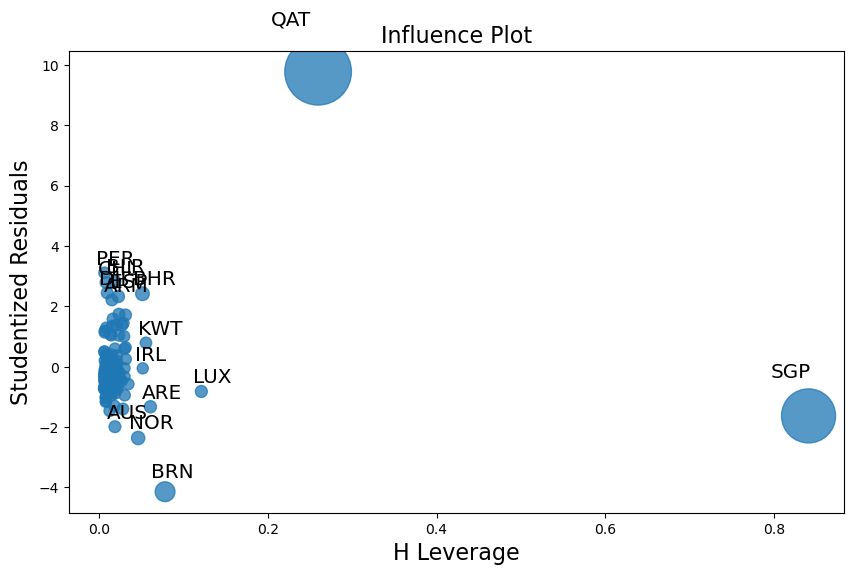

In [10]:
fig, ax = plt.subplots(figsize = (10, 6))
sm.graphics.influence_plot(lm, ax = ax, criterion='cooks')
plt.show()

### (5) 이상값 두 개를 빼고 모델 실행
- median_age와 상수에 대한 추정값은 더이상 유의하지 않음
- 이상치 2건을 제외한 결과, 모델에 극적인 효과가 있음

In [11]:
covidanalysisminusoutliers = covidanalysis.loc[influence.cooks_d < 0.5]
lm = getlm(covidanalysisminusoutliers)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     41.46
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           4.16e-20
Time:                        18:01:51   Log-Likelihood:                -1455.9
No. Observations:                 172   AIC:                             2920.
Df Residuals:                     168   BIC:                             2932.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.2490    349.194      0.067      0.947    -666.124     712.622
pop_density        0.6852      0.344      1.989      0.048       0.005       1.365
median_age        -4.6299     13.568     -0.341      0.733     -31.415      22.155
gdp_per_capita     0.0566      0.007      7.996      0.000       0.043       0.071
==============================================================================
Omnibus:                       49.511   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.477
Skew:                           1.269   Prob(JB):                     6.21e-25
Kurtosis:                       6.019   Cond. No.                     9.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""